In [3]:
import numpy as np
import rcca
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import normalize

import torch
import umap

# from mcfa import mcfa_model
# from mcfa import gsea
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from statsmodels.stats import multitest

In [4]:
ephys = pd.read_pickle("D:/Data For Publication/CCA/ephys_with_labels.p")
ephys = ephys.drop_duplicates('exp_name')
bio = pd.read_pickle("D:/Data For Publication/CCA/biophys_with_labels.pkl")
bio = bio.drop_duplicates('exp_name')
sta = pd.read_pickle("D:/Data For Publication/CCA/sta_with_labels.pkl")
sta = sta.drop_duplicates('exp_name')
# sta_fleur = pd.read_pickle('D:/CurrentClamp/all_stas_fleur.pkl')
# sta_fleur = sta_fleur.drop_duplicates('exp_name')
# sta_fleur = sta_fleur[sta_fleur.exp_name.isin(sta.exp_name)]

In [5]:
df_ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated_5ms.pkl")
df_bio = pd.read_pickle("D:/Biophysical_cluster/rect_bio_all_feats.pkl")
df_sta = pd.read_pickle('D:/CurrentClamp/all_stas_hidden_spikes_computed.pkl')


In [24]:
ephys_exc  = ephys[~ephys.labels_wave.isin([0,4,5])] 
ephys_inh  = ephys[ephys.labels_wave.isin([0,4,5])] 


bio_exc =  bio[bio.labels_wave==1]
bio_inh =  bio[bio.labels_wave==0]

bio_exc = bio_exc[bio_exc.r_squared_V>0.7]
bio_inh = bio_inh[bio_inh.r_squared_V>0.7]

sta_exc = sta[sta.labels_wave==1]
sta_inh = sta[sta.labels_wave==0]

sta_exc = sta[sta.labels_wave==1]
sta_inh = sta[sta.labels_wave==0]



exc_exps = list(set(sta_exc.exp_name) & set(bio_exc.exp_name) & set(ephys_exc.exp_name))
inh_exps = list(set(sta_inh.exp_name) & set(bio_inh.exp_name) & set(ephys_inh.exp_name))


ephys_exc = ephys_exc[ephys_exc.exp_name.isin(exc_exps)]
ephys_inh = ephys_inh[ephys_inh.exp_name.isin(inh_exps)]


ephys_exc_all = df_ephys[df_ephys.exp_name.isin(exc_exps)]
ephys_inh_all = df_ephys[df_ephys.exp_name.isin(inh_exps)]



bio_exc = bio_exc[bio_exc.exp_name.isin(exc_exps)]
bio_inh = bio_inh[bio_inh.exp_name.isin(inh_exps)]

bio_exc_all = df_bio[df_bio.exp_name.isin(exc_exps)]
bio_inh_all = df_bio[df_bio.exp_name.isin(inh_exps)]

sta_exc = sta_exc[sta_exc.exp_name.isin(exc_exps)]
sta_inh = sta_inh[sta_inh.exp_name.isin(inh_exps)]

sta_exc_all = df_sta[df_sta.exp_name.isin(exc_exps)]
sta_inh_all = df_sta[df_sta.exp_name.isin(inh_exps)]

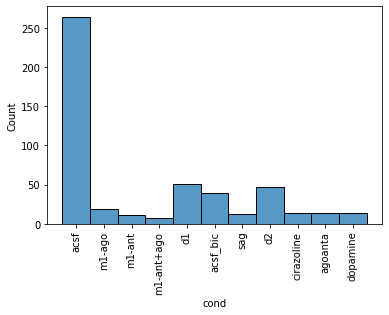

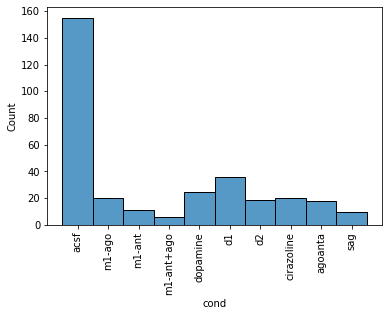

In [66]:
sns.histplot(df_ephys[df_ephys.exp_name.isin(exc_exps)].cond)
plt.xticks(rotation=90)
plt.show()

sns.histplot(df_ephys[df_ephys.exp_name.isin(inh_exps)].cond)
plt.xticks(rotation=90)
plt.show()

In [23]:
cols_ephys = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]
cols_bio = ['tau_m (ms)', 'C (nF)', 'gl (nS)', 'El (mV)', 'Vr (mV)', 'Vt* (mV)', 'DV (mV)',]

## control

In [31]:
df_sta_exc = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_exc[df_sta_exc.columns] = normalize(np.vstack(sta_exc['sta'].to_numpy()))
bio_exc[cols_bio] = bio_exc[cols_bio].to_numpy(dtype=np.float32)

df_eta_exc = pd.DataFrame(columns=np.arange(10759))

df_eta_exc[df_eta_exc.columns]  = normalize(np.float32(np.vstack(bio_exc['eta'].to_numpy())))

ephys_exc[cols_ephys] = ephys_exc[cols_ephys].to_numpy(dtype=np.float32)

In [32]:
df_sta_inh = pd.DataFrame(columns=np.arange(np.vstack(sta_exc['sta'].to_numpy()).shape[1]))
df_sta_inh[df_sta_inh.columns] =normalize(np.vstack(sta_inh['sta'].to_numpy()))
bio_inh[cols_bio] = bio_inh[cols_bio].to_numpy(dtype=np.float32)

df_eta_inh = pd.DataFrame(columns=np.arange(10759))
df_eta_inh[df_eta_inh.columns]  =  normalize(np.float32(np.vstack(bio_inh['eta'].to_numpy())))
ephys_inh[cols_ephys] = ephys_inh[cols_ephys].to_numpy(dtype=np.float32)

## neuromod

In [53]:
def return_neuromod_df(df:pd.DataFrame,cond:list,df_type:str,cols=None):

    if df_type=='sta':
        df_sta = pd.DataFrame(columns=np.arange(np.vstack(df['sta'].to_numpy()).shape[1]))
        df_sta[df_sta.columns] = normalize(np.vstack(df[df.cond.isin(cond)]['sta'].to_numpy()))
        return df_sta
    
    elif df_type=='bio':
        df_bio = pd.DataFrame(columns=cols)
        df_bio[cols] = df[df.cond.isin(cond)][cols].to_numpy(dtype=np.float32)
        return df_bio
    
    elif df_type=='eta':    
        df_eta_exc_all = pd.DataFrame(columns=np.arange(10759))
        df_eta_exc_all[df_eta_exc_all.columns]  = normalize(np.float32(np.vstack(df[df.cond.isin(cond)]['eta'].to_numpy())))
        return df_eta_exc_all
             
    elif df_type=='ephys':    
        df_ephys = pd.DataFrame(columns=cols)
        df_ephys[cols] = df[df.cond.isin(cond)][cols].to_numpy(dtype=np.float32)

        return df_ephys

# control

In [33]:
from multicor_fa import mcfa_model

Y_inh = {
    "ephys": ephys_inh[cols_ephys].reset_index(drop='index'), 
    "bio": bio_inh[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_inh,
    'eta':df_eta_inh
    }

Y_exc = {
    "ephys": ephys_exc[cols_ephys].reset_index(drop='index'), 
    "bio": bio_exc[cols_bio].reset_index(drop='index'), 
    "sta": df_sta_exc,
    'eta':df_eta_exc
    }



mcfa_res_inh = mcfa_model.fit(Y_inh,k=[2,1,2,2]) 
mcfa_res_exc = mcfa_model.fit(Y_exc,k=[2,1,2,2])    

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 3 components above rho inclusion threshold 1.59052312374115.
Fitting the model.
iter: 0 Likelihood: 7239.1962890625
Iter: 1 Likelihood: 7134.63720703125 Percent change: 0.014655136483773284 Time (s): 0.005981922149658203
Iter: 2 Likelihood: 7126.9130859375 Percent change: 0.0010837961682163466 Time (s): 0.01098179817199707
Iter: 3 Likelihood: 7123.3828125 Percent change: 0.0004955894594496777 Time (s): 0.016985654830932617
Iter: 4 Likelihood: 7121.4619140625 Percent change: 0.0002697337233113428 Time (s): 0.023981094360351562
Iter: 5 Likelihood: 7120.2138671875 Percent change: 0.00017528221739959916 Time (s): 0.02998495101928711
Iter: 6 Likelihood: 7119.2294921875 Percent change: 0.0001382698789356676 Time (s): 0.0369870662689209
Iter: 7 Likelihood: 7118.3486328125 Percent change: 0.00012374490495444692 Time (s): 0.04298758506774902
Iter: 8 Likelihood: 7117.513671875 Percent change: 0.0

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 4 components above rho inclusion threshold 1.5031743049621582.
Fitting the model.
iter: 0 Likelihood: 12319.09765625
Iter: 1 Likelihood: 12148.5390625 Percent change: 0.01403943246776715 Time (s): 0.004999399185180664
Iter: 2 Likelihood: 12137.8291015625 Percent change: 0.0008823621463018712 Time (s): 0.012005329132080078
Iter: 3 Likelihood: 12134.4755859375 Percent change: 0.0002763626331644978 Time (s): 0.018999576568603516
Iter: 4 Likelihood: 12132.7353515625 Percent change: 0.00014343297900880084 Time (s): 0.025022029876708984
Iter: 5 Likelihood: 12131.6025390625 Percent change: 9.337698761169115e-05 Time (s): 0.033014535903930664
Iter: 6 Likelihood: 12130.7646484375 Percent change: 6.907154241986916e-05 Time (s): 0.0395505428314209
Iter: 7 Likelihood: 12130.091796875 Percent change: 5.546961834809383e-05 Time (s): 0.04755568504333496
Iter: 8 Likelihood: 12129.5263671875 Percent cha

In [34]:
mcfa_res_df_inh = pd.concat([mcfa_res_inh.Z] + list(mcfa_res_inh.X.values()), axis=1)
mcfa_res_df_exc = pd.concat([mcfa_res_exc.Z] + list(mcfa_res_exc.X.values()), axis=1)

In [52]:

var_exp_private_exc = {mode: ve_X.sum() for mode, ve_X in mcfa_res_exc.var_exp_X.items()}
var_exp_shared_exc = mcfa_res_exc.var_exp_Z.sum()
var_exp_totals_exc = pd.DataFrame({'Shared': var_exp_shared_exc, 'Specific': var_exp_private_exc})
var_exp_totals_exc['Total'] = var_exp_totals_exc['Shared'] + var_exp_totals_exc['Specific']
var_exp_normed_exc = (mcfa_res_exc.var_exp_Z/var_exp_totals_exc['Total']).T
var_exp_totals_exc['Residual'] = 1 - var_exp_totals_exc['Total']
var_exp_totals_exc = var_exp_totals_exc.drop('Total', axis=1)


var_exp_private_inh = {mode: ve_X.sum() for mode, ve_X in mcfa_res_inh.var_exp_X.items()}
var_exp_shared_inh = mcfa_res_inh.var_exp_Z.sum()
var_exp_totals_inh = pd.DataFrame({'Shared': var_exp_shared_inh, 'Specific': var_exp_private_inh})
var_exp_totals_inh['Total'] = var_exp_totals_inh['Shared'] + var_exp_totals_inh['Specific']
var_exp_normed_inh = (mcfa_res_inh.var_exp_Z/var_exp_totals_inh['Total']).T
var_exp_totals_inh['Residual'] = 1 - var_exp_totals_inh['Total']
var_exp_totals_inh = var_exp_totals_inh.drop('Total', axis=1)

In [53]:
var_exp_totals_exc

,Shared,Specific,Residual
ephys,0.523925,0.127760,0.348314
bio,0.519240,0.022429,0.458331
sta,0.329911,0.571757,0.098332
eta,0.197586,0.412426,0.389987


In [54]:

var_exp_totals_exc['dataset'] = var_exp_totals_exc.index
var_exp_totals_exc = var_exp_totals_exc.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

var_exp_totals_inh['dataset'] = var_exp_totals_inh.index
var_exp_totals_inh = var_exp_totals_inh.melt(id_vars=['dataset'], var_name='Space', value_name='Variance explained')

In [55]:
var_exp_totals_exc = var_exp_totals_exc.reindex([0,1,3,2,4,5,7,6,8,9,11,10])
var_exp_totals_exc


,dataset,Space,Variance explained
0,ephys,Shared,0.523925
1,bio,Shared,0.519240
3,eta,Shared,0.197586
2,sta,Shared,0.329911
4,ephys,Specific,0.127760
5,bio,Specific,0.022429
7,eta,Specific,0.412426
6,sta,Specific,0.571757
8,ephys,Residual,0.348314
9,bio,Residual,0.458331


In [56]:
var_exp_totals_inh = var_exp_totals_inh.reindex([0,1,3,2,4,5,7,6,8,9,11,10])
var_exp_totals_inh

,dataset,Space,Variance explained
0,ephys,Shared,0.339656
1,bio,Shared,0.338548
3,eta,Shared,0.294900
2,sta,Shared,0.099907
4,ephys,Specific,0.357589
5,bio,Specific,0.171724
7,eta,Specific,0.362958
6,sta,Specific,0.806163
8,ephys,Residual,0.302754
9,bio,Residual,0.489728


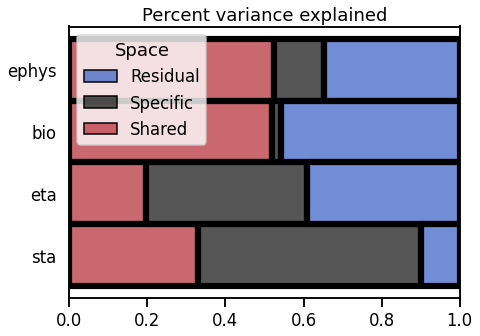

<ipython-input-71-b117f348b41c>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=['ephys', 'bio','eta','sta'])


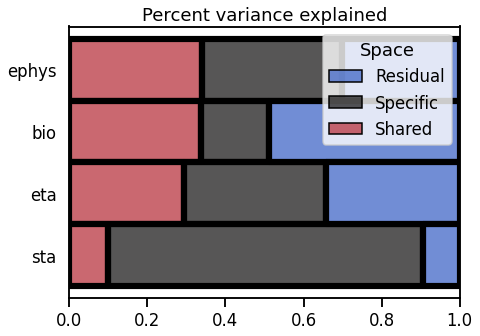

In [71]:
# sns.set_context('talk')
savepath = 'D:/Data For Publication/figures/part2/'
fig,ax = plt.subplots(figsize=(7, 5))
var_exp_totals_exc['Space'] = pd.Categorical(var_exp_totals_exc['Space'], ['Residual', 'Specific', 'Shared'])
sns.histplot(var_exp_totals_exc, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire',ax =ax)
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set_yticklabels=['ephys','bio','eta','sta']
plt.savefig(savepath+'alpha_exc.svg',dpi=100)
plt.show() 

# fig,ax = plt.subplots(figsize=(7, 5))

sns.set_context('talk')
plt.figure(figsize=(7, 5))
var_exp_totals_inh['Space'] = pd.Categorical(var_exp_totals_inh['Space'], ['Residual', 'Specific', 'Shared'])
ax = sns.histplot(var_exp_totals_inh, y='dataset', hue='Space', weights='Variance explained',
             multiple='stack', palette='icefire')
ax.set(title='Percent variance explained', xlabel=None, ylabel=None)
ax.set_xlim(0, 1)
ax.tick_params(left=False)
ax.set(yticklabels=['ephys', 'bio','eta','sta'])
plt.savefig(savepath+'beta_inh.svg',dpi=100)

plt.show() 

In [67]:
var_exp_normed_exc = var_exp_normed_exc.reindex(['ephys','bio','eta','sta'])
var_exp_normed_inh = var_exp_normed_inh.reindex(['ephys','bio','eta','sta'])



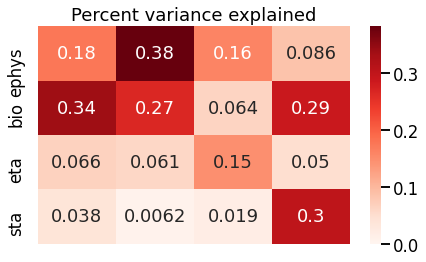

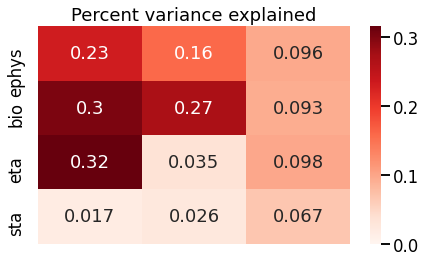

In [68]:

sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_exc, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'exc_var_per_factor.pdf',dpi=200)
plt.show()


sns.set_context('talk')
plt.figure(figsize=(7, 4))
ax = sns.heatmap(var_exp_normed_inh, vmin=0, cmap='Reds',annot=True)
ax.set(xlabel=None, title='Percent variance explained', xticklabels=[])
ax.tick_params(bottom=False, left=False)
plt.savefig(savepath+'inh_var_per_factor.pdf',dpi=200)

plt.show()

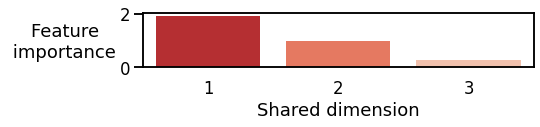

In [283]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_inh.rho.index, y=mcfa_res_inh.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 4))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_inh.pdf',dpi=200)
plt.show()

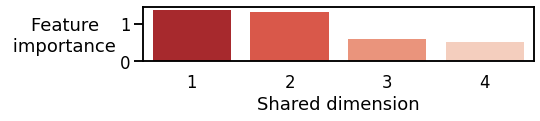

In [284]:
sns.set_context('talk')
plt.figure(figsize=(7, 1))
ax = sns.barplot(x=mcfa_res_exc.rho.index, y=mcfa_res_exc.rho, palette='Reds_r')
ax.set_ylabel('Feature   \n importance', rotation=0, y=0.1, ha='right')
ax.tick_params(bottom=False)
ax.set(xticklabels=range(1, 5))
ax.set(xlabel='Shared dimension')
plt.savefig(savepath+'shared_dim_exc.pdf',dpi=200)
plt.show()

# D1

In [71]:
from multicor_fa import mcfa_model
drug = ['d2']

ephys_drug_exc = return_neuromod_df(ephys_exc_all,cond=drug,cols=cols_ephys,df_type='ephys')
sta_drug_exc = return_neuromod_df(sta_exc_all,cond=drug,df_type='sta')
bio_drug_exc = return_neuromod_df(bio_exc_all,cond=drug,df_type='bio',cols=cols_bio)
eta_drug_exc = return_neuromod_df(bio_exc_all,cond=drug,df_type='eta')


ephys_drug_inh = return_neuromod_df(ephys_inh_all,cond=drug,cols=cols_ephys,df_type='ephys')
sta_drug_inh = return_neuromod_df(sta_inh_all,cond=drug,df_type='sta')
bio_drug_inh = return_neuromod_df(bio_inh_all,cond=drug,df_type='bio',cols=cols_bio)
eta_drug_inh = return_neuromod_df(bio_inh_all,cond=drug,df_type='eta')


Y_inh = {"ephys": ephys_drug_inh[cols_ephys].reset_index(drop='index'), 
    "bio": bio_drug_inh[cols_bio].reset_index(drop='index'), 
    "sta": sta_drug_inh,
    'eta':eta_drug_inh}

Y_exc = {"ephys": ephys_drug_exc[cols_ephys].reset_index(drop='index'), 
    "bio": bio_drug_exc[cols_bio].reset_index(drop='index'), 
    "sta": sta_drug_exc,
    'eta':eta_drug_exc}



mcfa_res_inh = mcfa_model.fit(Y_inh,k=[1,1,1,1]) 
mcfa_res_exc = mcfa_model.fit(Y_exc,k=[1,1,1,1]) 

Calculating data PCs.


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

Calculating exmpirical covariance.
Initialzing model.
Inferring the shared dimensionality.
There are 2 components above rho inclusion threshold 1.9450050592422485.
Fitting the model.


RuntimeError: false INTERNAL ASSERT FAILED at "C:\\actions-runner\\_work\\pytorch\\pytorch\\builder\\windows\\pytorch\\aten\\src\\ATen\\native\\BatchLinearAlgebra.cpp":1538, please report a bug to PyTorch. torch.linalg.lstsq: Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.